## AnySolar panel optimiser

This notebook optimises the placement of IXOLAR (bought by [ANYSOLAR](https://www.anysolar.biz/)) small solar cells for placement on a PCB.

Change the constants on the cell below to define the maximum dimensions of the PCB, the maximum area you want covered (to allow for space for other components), and the minimum fill ratio of this available area to be considered.

Information about the available options for cells is fetched from an adjacent csv file.

In [30]:
import coloredlogs, logging
import pandas as pd
from collections import Counter
from tqdm.notebook import tqdm
from IPython.display import HTML, display

# Create a logger object.
logger = logging.getLogger(__name__)

# By default the install() function installs a handler on the root logger,
# this means that log messages from your code and log messages from the
# libraries that you use will all show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)

logger.debug("Welcome to program")

AVAILABLE_X = 70
AVAILABLE_Y = 70
AVAILABLE_AREA = 30 * 70
FILL_RATIO = 0.70

2024-04-22 17:08:55 pp2233 __main__[38468] DEBUG Welcome to program


In [31]:
df = pd.read_csv('panels2.csv').dropna(subset='Current')
df.drop(index=0, inplace=True)
df = df.apply(pd.to_numeric, errors='ignore')
df.sort_values(by=['Area'], inplace=True, ignore_index=True)
df.drop(columns=['Datasheet'])

,Panel,Voltage,Current,Power,Dimen Long,Dimen Short,Unnamed: 7,Area,Efficacy,Unnamed: 10,Effective width (compared to max efficacy),Unnamed: 12,Unnamed: 13
0,KXOB25-04X3F-TR,1.67,13.2,22.0,22.0,7.0,NaN,154,143.14,NaN,15,NaN,NaN
1,KXOB25-12X1F-TR,0.56,43.9,24.6,22.0,7.0,NaN,154,159.64,NaN,17,NaN,NaN
2,KXOB25-01X8F-TB,4.46,5.5,24.5,22.0,7.0,NaN,154,159.29,NaN,17,NaN,NaN
3,KXOB25-02X8F-TB,4.46,6.3,28.1,23.0,8.0,NaN,184,152.71,NaN,17,NaN,NaN
4,KXOB25-03X4F-TR,2.23,13.5,30.1,23.0,8.0,NaN,184,163.61,NaN,18,NaN,NaN
5,KXOB25-05X3F-TR,1.67,18.4,30.7,23.0,8.0,NaN,184,167.00,NaN,18,NaN,NaN
6,KXOB25-14X1F-TR,0.56,55.0,30.8,23.0,8.0,NaN,184,167.39,NaN,18,NaN,NaN
7,SM400K10L,5.58,15.4,86.0,33.0,15.0,NaN,495,173.60,NaN,27,NaN,NaN
8,SM340K10L,5.58,13.2,74.0,34.0,16.0,NaN,544,135.40,NaN,22,NaN,NaN
9,KXOB121K04F-TR,2.23,47.2,105.0,25.0,23.0,NaN,575,183.05,NaN,22,NaN,NaN


In [33]:
combinations = [ ]

pbar = tqdm(list(df.iterrows()))

def mysum(combination, attr):
    return df.loc[combination, attr].astype('float').sum()

def investigate_combination(combi):
    start = combi[-1]
    for idx, panel in df.loc[start:].iterrows():
        combi2 = combi.copy()
        combi2.append(idx)

        # Are all elements in combi2 equal?
        if len(set(combi2)) > 2:
            continue
        
        area = mysum(combi2, 'Area')

        if area >= AVAILABLE_AREA:
            break
            
        investigate_combination(combi2)
            
        if area < AVAILABLE_AREA * FILL_RATIO:
            continue
            
            
        
        combinations.append({
            "Combination": combi2,
            "Area": area,
            "Power": mysum(combi2, 'Power')
        })
        pbar.set_postfix_str("{} combinations found / depth = {}. {}".format(len(combinations), len(combi2), combi), refresh=True)

for idx, panel in pbar:
    investigate_combination([ idx ])
            
    

  0%|          | 0/36 [00:00<?, ?it/s]

In [34]:
combinations

[{'Combination': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'Area': 2002.0,
  'Power': 286.0},
 {'Combination': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  'Area': 2002.0,
  'Power': 288.6},
 {'Combination': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
  'Area': 2002.0,
  'Power': 288.5},
 {'Combination': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
  'Area': 2032.0,
  'Power': 292.1},
 {'Combination': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4],
  'Area': 2032.0,
  'Power': 294.1},
 {'Combination': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5],
  'Area': 2032.0,
  'Power': 294.7},
 {'Combination': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6],
  'Area': 2032.0,
  'Power': 294.8},
 {'Combination': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'Area': 1848.0,
  'Power': 264.0},
 {'Combination': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
  'Area': 2002.0,
  'Power': 291.20000000000005},
 {'Combination': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  'Area': 1848.0,
  'Power': 266.6},
 {'Combination': [0, 0, 0, 0, 0, 0, 0, 0, 0

In [35]:
parsed_combinations = pd.DataFrame(combinations)
pc = parsed_combinations
pc['Fill Ratio'] = pc['Area'] / AVAILABLE_AREA
pc['Empty Ratio'] = 1-pc['Fill Ratio']
pc['Efficacy'] = pc['Power'] / pc['Area']
pc

,Combination,Area,Power,Fill Ratio,Empty Ratio,Efficacy
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",2002.0,286.0,0.953333,0.046667,0.142857
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",2002.0,288.6,0.953333,0.046667,0.144156
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]",2002.0,288.5,0.953333,0.046667,0.144106
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3]",2032.0,292.1,0.967619,0.032381,0.143750
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4]",2032.0,294.1,0.967619,0.032381,0.144734
...,...,...,...,...,...,...
2157,"[22, 26]",2047.0,381.0,0.974762,0.025238,0.186126
2158,"[23, 23]",1932.0,370.0,0.920000,0.080000,0.191511
2159,"[23, 24]",2022.0,374.0,0.962857,0.037143,0.184965
2160,"[23, 25]",2039.0,369.0,0.970952,0.029048,0.180971


In [45]:
#pc.sort_values(by=['Power', 'Empty Ratio'], inplace=True, ascending=False)
pc.sort_values(by=['Efficacy', 'Power'], inplace=True, ascending=False)
pc

,Combination,Area,Power,Fill Ratio,Empty Ratio,Efficacy
2077,"[15, 15]",1540.0,326.0,0.733333,0.266667,0.211688
741,"[1, 15, 15]",1694.0,350.6,0.806667,0.193333,0.206966
1856,"[6, 15, 15]",1724.0,356.8,0.820952,0.179048,0.206961
1054,"[2, 15, 15]",1694.0,350.5,0.806667,0.193333,0.206907
1707,"[5, 15, 15]",1724.0,356.7,0.820952,0.179048,0.206903
...,...,...,...,...,...,...
1300,"[3, 8, 8, 8]",1816.0,250.1,0.864762,0.135238,0.137720
301,"[0, 0, 0, 8, 8, 8]",2094.0,288.0,0.997143,0.002857,0.137536
341,"[0, 0, 8, 8, 8]",1940.0,266.0,0.923810,0.076190,0.137113
379,"[0, 8, 8, 8]",1786.0,244.0,0.850476,0.149524,0.136618


In [47]:
import rpack
#import rpack.misc.recstat

finds = 0

for idx, combi in pc.iterrows():
    combination = combi['Combination']
    #print(combination)
    
    if combi['Area'] >= AVAILABLE_AREA:
        print("Combination {} area {:.2f} > {:.2f}, ignored".format(combination, combi['Area'], AVAILABLE_AREA))
        continue
        
    if len(Counter(combination)) > 1:
        print("Combination {} has {} duplicates, ignored".format(combination, len(Counter(combination))))
        continue
    
    panels = df.iloc[combination]
    panels_orig = panels
    panels = panels[['Dimen Long', 'Dimen Short']]
    panels = list(panels.astype('int').itertuples(index=False, name=None))
    
    try:
        positions = rpack.pack(panels, max_width=AVAILABLE_X, max_height=AVAILABLE_Y)
    except:
        try:
            positions = rpack.pack(panels, max_width=AVAILABLE_Y, max_height=AVAILABLE_X)
        except Exception as e:
            print("Combination {} cannot be packed because {}".format(combination, e))
            continue
            
    print(panels)
    print(positions)

    bbox = rpack.bbox_size(panels, positions)
    density = rpack.packing_density(panels, positions)

    print("Bounding Box = {}, density = {}".format(bbox, density))

    print(len(Counter(combination)))
    print("Found on combination #{}".format(idx))
    display(combi)
    display(panels_orig)
    finds += 1

    if finds >= 1:
        break
    


[(35, 22), (35, 22)]
[(35, 0), (0, 0)]
Bounding Box = (70, 22), density = 1.0
1
Found on combination #2077


Combination    [15, 15]
Area             1540.0
Power             326.0
Fill Ratio     0.733333
Empty Ratio    0.266667
Efficacy       0.211688
Name: 2077, dtype: object

,Panel,Voltage,Current,Power,Dimen Long,Dimen Short,Datasheet,Unnamed: 7,Area,Efficacy,Unnamed: 10,Effective width (compared to max efficacy),Unnamed: 12,Unnamed: 13
15,SM141K05L,2.79,58.6,163.0,35.0,22.0,https://waf-e.dubudisk.com/anysolar.dubuplus.c...,NaN,770,212.33,NaN,35,NaN,KXOB series: SMT capable series. Fixed form fa...
15,SM141K05L,2.79,58.6,163.0,35.0,22.0,https://waf-e.dubudisk.com/anysolar.dubuplus.c...,NaN,770,212.33,NaN,35,NaN,KXOB series: SMT capable series. Fixed form fa...


In [48]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick
import  matplotlib.animation as mani

def rectangle_color(w, h):
    r = min(w, h)/max(w, h)/2
    if h < w:
        r = 1 - r
    r = r/2 + 0.3
    return plt.get_cmap('viridis')(r)

class PlotPacking:

    def __init__(self, rec, pos, gridlines=False, title='', trim=False):
        """Initialization of PlotPacking"""
        self.rec = rec
        self.pos = pos
        self.gridlines = gridlines
        self.index = None
        self.encl_w, self.encl_h = rpack.enclosing_size(rec, pos)
        self.density = sum(w*h for w, h in rec)/(self.encl_w*self.encl_h)
        if trim:
            self.fig = plt.figure(figsize=(6, 6*self.encl_h/self.encl_w))
            self.ax = self.fig.add_axes([0.01, 0.01, 0.98, 0.98])
        else:
            self.fig, self.ax = plt.subplots(tight_layout=True)
            self.ax.set_aspect('equal')
        self.ax.invert_yaxis()
        self.ax.set_xlim([0, self.encl_w])
        self.ax.set_ylim([self.encl_h, 0])
        self.ax.xaxis.set_visible(False)
        self.ax.yaxis.set_visible(False)
        if title and not trim:
            self.ax.set_title(
                f'Packing density {100*self.density:.2f}% '
                f'({self.encl_w} x {self.encl_h})' + title)

    def feed(self, *args):
        artists = list()
        if self.index is None:
            self.index = 0
            return [self.ax]
        try:
            w, h = self.rec[self.index]
            x, y = self.pos[self.index]
        except IndexError:
            return []
        else:
            p = patches.Rectangle(
                (x, y), w, h,
                edgecolor='k',
                facecolor=rectangle_color(w, h)
            )
            self.ax.add_patch(p)
            artists.append(p)
            if self.gridlines:
                hline = self.ax.axhline(y+h, color='k', linestyle='-', linewidth=0.5)
                vline = self.ax.axvline(x+w, color='k', linestyle='-', linewidth=0.5)
                artists.append(hline)
                artists.append(vline)
            self.index += 1
            return artists
    
    def display(self):
        plt.show()

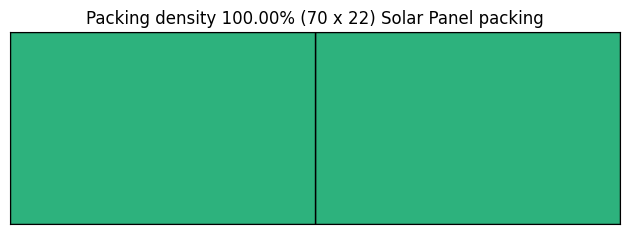

: 

In [49]:
pp = PlotPacking(panels, positions, title=' Solar Panel packing')
while len(pp.feed()) >= 1:
    pass
pp.display()